# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 0           

# --- Training configuration ---
epochs = 4000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/4000: Train Loss 2.3390 | Test Loss 2.2499 | accs Train 0.0667 Test 0.2833


Epoch 100/4000: Train Loss 0.0001 | Test Loss 2.1717 | accs Train 1.0000 Test 0.6319


Epoch 200/4000: Train Loss 0.0001 | Test Loss 2.1954 | accs Train 1.0000 Test 0.6327


Epoch 300/4000: Train Loss 0.0000 | Test Loss 2.2271 | accs Train 1.0000 Test 0.6330


Epoch 400/4000: Train Loss 0.0000 | Test Loss 2.2544 | accs Train 1.0000 Test 0.6339


Epoch 500/4000: Train Loss 0.0000 | Test Loss 2.2789 | accs Train 1.0000 Test 0.6335


Epoch 600/4000: Train Loss 0.0000 | Test Loss 2.3012 | accs Train 1.0000 Test 0.6338


Epoch 700/4000: Train Loss 0.0000 | Test Loss 2.3217 | accs Train 1.0000 Test 0.6346


Epoch 800/4000: Train Loss 0.0000 | Test Loss 2.3408 | accs Train 1.0000 Test 0.6344


Epoch 900/4000: Train Loss 0.0000 | Test Loss 2.3578 | accs Train 1.0000 Test 0.6344


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 2.3734 | accs Train 1.0000 Test 0.6340


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 2.3897 | accs Train 1.0000 Test 0.6343


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 2.4045 | accs Train 1.0000 Test 0.6342


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 2.4179 | accs Train 1.0000 Test 0.6347


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 2.4298 | accs Train 1.0000 Test 0.6347


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 2.4404 | accs Train 1.0000 Test 0.6350


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 2.4500 | accs Train 1.0000 Test 0.6356


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 2.4585 | accs Train 1.0000 Test 0.6356


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 2.4672 | accs Train 1.0000 Test 0.6358


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 2.4753 | accs Train 1.0000 Test 0.6356


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 2.4839 | accs Train 1.0000 Test 0.6354


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 2.4922 | accs Train 1.0000 Test 0.6353


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 2.5004 | accs Train 1.0000 Test 0.6355


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 2.5081 | accs Train 1.0000 Test 0.6357


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 2.5157 | accs Train 1.0000 Test 0.6357


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 2.5232 | accs Train 1.0000 Test 0.6357


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 2.5303 | accs Train 1.0000 Test 0.6363


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 2.5372 | accs Train 1.0000 Test 0.6364


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 2.5443 | accs Train 1.0000 Test 0.6363


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 2.5507 | accs Train 1.0000 Test 0.6364


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 2.5574 | accs Train 1.0000 Test 0.6364


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 2.5642 | accs Train 1.0000 Test 0.6365


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 2.5710 | accs Train 1.0000 Test 0.6366


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 2.5774 | accs Train 1.0000 Test 0.6365


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 2.5840 | accs Train 1.0000 Test 0.6365


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 2.5909 | accs Train 1.0000 Test 0.6365


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 2.5968 | accs Train 1.0000 Test 0.6369


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 2.6035 | accs Train 1.0000 Test 0.6367


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 2.6098 | accs Train 1.0000 Test 0.6366


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 2.6161 | accs Train 1.0000 Test 0.6365


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 2.6215 | accs Train 1.0000 Test 0.6367
Completed training with 0 additional samples of data
Epoch 1/4000: Train Loss 2.3157 | Test Loss 2.1965 | accs Train 0.0867 Test 0.3463


Epoch 100/4000: Train Loss 0.0016 | Test Loss 0.6539 | accs Train 1.0000 Test 0.8692


Epoch 200/4000: Train Loss 0.0005 | Test Loss 0.7068 | accs Train 1.0000 Test 0.8701


Epoch 300/4000: Train Loss 0.0003 | Test Loss 0.7413 | accs Train 1.0000 Test 0.8699


Epoch 400/4000: Train Loss 0.0002 | Test Loss 0.7665 | accs Train 1.0000 Test 0.8694


Epoch 500/4000: Train Loss 0.0001 | Test Loss 0.7864 | accs Train 1.0000 Test 0.8699


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.8026 | accs Train 1.0000 Test 0.8697


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.8163 | accs Train 1.0000 Test 0.8696


Epoch 800/4000: Train Loss 0.0000 | Test Loss 0.8282 | accs Train 1.0000 Test 0.8700


Epoch 900/4000: Train Loss 0.0000 | Test Loss 0.8387 | accs Train 1.0000 Test 0.8700


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 0.8480 | accs Train 1.0000 Test 0.8704


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.8564 | accs Train 1.0000 Test 0.8707


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.8642 | accs Train 1.0000 Test 0.8707


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.8713 | accs Train 1.0000 Test 0.8708


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.8778 | accs Train 1.0000 Test 0.8708


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.8840 | accs Train 1.0000 Test 0.8707


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.8897 | accs Train 1.0000 Test 0.8708


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.8951 | accs Train 1.0000 Test 0.8706


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.9003 | accs Train 1.0000 Test 0.8708


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.9051 | accs Train 1.0000 Test 0.8708


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.9097 | accs Train 1.0000 Test 0.8707


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.9142 | accs Train 1.0000 Test 0.8708


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.9183 | accs Train 1.0000 Test 0.8708


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.9224 | accs Train 1.0000 Test 0.8708


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.9262 | accs Train 1.0000 Test 0.8707


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.9300 | accs Train 1.0000 Test 0.8707


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.9336 | accs Train 1.0000 Test 0.8707


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.9371 | accs Train 1.0000 Test 0.8707


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.9405 | accs Train 1.0000 Test 0.8707


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.9438 | accs Train 1.0000 Test 0.8709


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.9470 | accs Train 1.0000 Test 0.8714


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.9501 | accs Train 1.0000 Test 0.8715


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.9532 | accs Train 1.0000 Test 0.8717


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.9562 | accs Train 1.0000 Test 0.8718


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.9591 | accs Train 1.0000 Test 0.8717


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.9620 | accs Train 1.0000 Test 0.8716


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.9648 | accs Train 1.0000 Test 0.8715


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.9676 | accs Train 1.0000 Test 0.8715


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.9704 | accs Train 1.0000 Test 0.8713


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.9732 | accs Train 1.0000 Test 0.8714


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.9759 | accs Train 1.0000 Test 0.8714
Completed training with 540 additional samples of data
Epoch 1/4000: Train Loss 2.3141 | Test Loss 2.1853 | accs Train 0.0755 Test 0.4969


Epoch 100/4000: Train Loss 0.0079 | Test Loss 0.4280 | accs Train 1.0000 Test 0.9063


Epoch 200/4000: Train Loss 0.0014 | Test Loss 0.4976 | accs Train 1.0000 Test 0.9083


Epoch 300/4000: Train Loss 0.0006 | Test Loss 0.5321 | accs Train 1.0000 Test 0.9089


Epoch 400/4000: Train Loss 0.0003 | Test Loss 0.5557 | accs Train 1.0000 Test 0.9092


Epoch 500/4000: Train Loss 0.0002 | Test Loss 0.5736 | accs Train 1.0000 Test 0.9092


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.5879 | accs Train 1.0000 Test 0.9095


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.5997 | accs Train 1.0000 Test 0.9090


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.6098 | accs Train 1.0000 Test 0.9090


Epoch 900/4000: Train Loss 0.0001 | Test Loss 0.6187 | accs Train 1.0000 Test 0.9094


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.6265 | accs Train 1.0000 Test 0.9092


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.6336 | accs Train 1.0000 Test 0.9092


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.6399 | accs Train 1.0000 Test 0.9093


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.6459 | accs Train 1.0000 Test 0.9096


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.6513 | accs Train 1.0000 Test 0.9099


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.6564 | accs Train 1.0000 Test 0.9098


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.6612 | accs Train 1.0000 Test 0.9099


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.6657 | accs Train 1.0000 Test 0.9099


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.6700 | accs Train 1.0000 Test 0.9100


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.6741 | accs Train 1.0000 Test 0.9105


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.6780 | accs Train 1.0000 Test 0.9106


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.6817 | accs Train 1.0000 Test 0.9111


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.6853 | accs Train 1.0000 Test 0.9112


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.6887 | accs Train 1.0000 Test 0.9112


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.6920 | accs Train 1.0000 Test 0.9111


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.6952 | accs Train 1.0000 Test 0.9110


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.6984 | accs Train 1.0000 Test 0.9110


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.7014 | accs Train 1.0000 Test 0.9109


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.7043 | accs Train 1.0000 Test 0.9111


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.7072 | accs Train 1.0000 Test 0.9114


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.7100 | accs Train 1.0000 Test 0.9114


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.7127 | accs Train 1.0000 Test 0.9112


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.7154 | accs Train 1.0000 Test 0.9112


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.7181 | accs Train 1.0000 Test 0.9113


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.7208 | accs Train 1.0000 Test 0.9111


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.7234 | accs Train 1.0000 Test 0.9114


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.7259 | accs Train 1.0000 Test 0.9115


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.7285 | accs Train 1.0000 Test 0.9117


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.7310 | accs Train 1.0000 Test 0.9117


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.7335 | accs Train 1.0000 Test 0.9116


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.7359 | accs Train 1.0000 Test 0.9115
Completed training with 1940 additional samples of data
Epoch 1/4000: Train Loss 2.3149 | Test Loss 2.1817 | accs Train 0.0752 Test 0.5014


Epoch 100/4000: Train Loss 0.0385 | Test Loss 0.2324 | accs Train 0.9938 Test 0.9384


Epoch 200/4000: Train Loss 0.0033 | Test Loss 0.2753 | accs Train 1.0000 Test 0.9401


Epoch 300/4000: Train Loss 0.0011 | Test Loss 0.3009 | accs Train 1.0000 Test 0.9406


Epoch 400/4000: Train Loss 0.0006 | Test Loss 0.3173 | accs Train 1.0000 Test 0.9411


Epoch 500/4000: Train Loss 0.0004 | Test Loss 0.3295 | accs Train 1.0000 Test 0.9416


Epoch 600/4000: Train Loss 0.0002 | Test Loss 0.3392 | accs Train 1.0000 Test 0.9418


Epoch 700/4000: Train Loss 0.0002 | Test Loss 0.3473 | accs Train 1.0000 Test 0.9418


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.3543 | accs Train 1.0000 Test 0.9420


Epoch 900/4000: Train Loss 0.0001 | Test Loss 0.3604 | accs Train 1.0000 Test 0.9423


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.3659 | accs Train 1.0000 Test 0.9423


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.3708 | accs Train 1.0000 Test 0.9422


Epoch 1200/4000: Train Loss 0.0001 | Test Loss 0.3753 | accs Train 1.0000 Test 0.9421


Epoch 1300/4000: Train Loss 0.0001 | Test Loss 0.3794 | accs Train 1.0000 Test 0.9420


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.3831 | accs Train 1.0000 Test 0.9420


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.3866 | accs Train 1.0000 Test 0.9421


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.3898 | accs Train 1.0000 Test 0.9423


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.3929 | accs Train 1.0000 Test 0.9423


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.3958 | accs Train 1.0000 Test 0.9422


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.3985 | accs Train 1.0000 Test 0.9424


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.4012 | accs Train 1.0000 Test 0.9425


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.4036 | accs Train 1.0000 Test 0.9426


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.4060 | accs Train 1.0000 Test 0.9427


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.4084 | accs Train 1.0000 Test 0.9426


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.4106 | accs Train 1.0000 Test 0.9426


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.4127 | accs Train 1.0000 Test 0.9428


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.4148 | accs Train 1.0000 Test 0.9429


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.4168 | accs Train 1.0000 Test 0.9427


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.4187 | accs Train 1.0000 Test 0.9428


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.4206 | accs Train 1.0000 Test 0.9427


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.4224 | accs Train 1.0000 Test 0.9425


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.4242 | accs Train 1.0000 Test 0.9425


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.4259 | accs Train 1.0000 Test 0.9426


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.4276 | accs Train 1.0000 Test 0.9426


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.4293 | accs Train 1.0000 Test 0.9426


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.4310 | accs Train 1.0000 Test 0.9427


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.4326 | accs Train 1.0000 Test 0.9427


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.4343 | accs Train 1.0000 Test 0.9428


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.4358 | accs Train 1.0000 Test 0.9428


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.4374 | accs Train 1.0000 Test 0.9427


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.4389 | accs Train 1.0000 Test 0.9427
Completed training with 5940 additional samples of data
Epoch 1/4000: Train Loss 2.3159 | Test Loss 2.1809 | accs Train 0.0747 Test 0.5130


Epoch 100/4000: Train Loss 0.0956 | Test Loss 0.1498 | accs Train 0.9740 Test 0.9565


Epoch 200/4000: Train Loss 0.0127 | Test Loss 0.1291 | accs Train 0.9993 Test 0.9672


Epoch 300/4000: Train Loss 0.0029 | Test Loss 0.1474 | accs Train 1.0000 Test 0.9664


Epoch 400/4000: Train Loss 0.0013 | Test Loss 0.1597 | accs Train 1.0000 Test 0.9662


Epoch 500/4000: Train Loss 0.0007 | Test Loss 0.1688 | accs Train 1.0000 Test 0.9667


Epoch 600/4000: Train Loss 0.0005 | Test Loss 0.1758 | accs Train 1.0000 Test 0.9670


Epoch 700/4000: Train Loss 0.0003 | Test Loss 0.1817 | accs Train 1.0000 Test 0.9670


Epoch 800/4000: Train Loss 0.0002 | Test Loss 0.1868 | accs Train 1.0000 Test 0.9671


Epoch 900/4000: Train Loss 0.0002 | Test Loss 0.1912 | accs Train 1.0000 Test 0.9673


Epoch 1000/4000: Train Loss 0.0002 | Test Loss 0.1951 | accs Train 1.0000 Test 0.9671


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.1986 | accs Train 1.0000 Test 0.9673


Epoch 1200/4000: Train Loss 0.0001 | Test Loss 0.2018 | accs Train 1.0000 Test 0.9673


Epoch 1300/4000: Train Loss 0.0001 | Test Loss 0.2048 | accs Train 1.0000 Test 0.9673


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.2075 | accs Train 1.0000 Test 0.9673


Epoch 1500/4000: Train Loss 0.0001 | Test Loss 0.2100 | accs Train 1.0000 Test 0.9675


Epoch 1600/4000: Train Loss 0.0001 | Test Loss 0.2124 | accs Train 1.0000 Test 0.9676


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.2146 | accs Train 1.0000 Test 0.9677


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.2167 | accs Train 1.0000 Test 0.9678


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.2186 | accs Train 1.0000 Test 0.9677


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.2205 | accs Train 1.0000 Test 0.9676


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.2223 | accs Train 1.0000 Test 0.9675


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.2240 | accs Train 1.0000 Test 0.9676


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.2256 | accs Train 1.0000 Test 0.9677


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.2272 | accs Train 1.0000 Test 0.9677


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.2287 | accs Train 1.0000 Test 0.9677


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.2302 | accs Train 1.0000 Test 0.9676


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.2317 | accs Train 1.0000 Test 0.9676


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.2331 | accs Train 1.0000 Test 0.9674


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.2345 | accs Train 1.0000 Test 0.9673


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.2358 | accs Train 1.0000 Test 0.9673


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.2371 | accs Train 1.0000 Test 0.9673


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.2384 | accs Train 1.0000 Test 0.9672


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.2397 | accs Train 1.0000 Test 0.9673


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.2409 | accs Train 1.0000 Test 0.9673


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.2421 | accs Train 1.0000 Test 0.9674


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.2433 | accs Train 1.0000 Test 0.9676


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.2445 | accs Train 1.0000 Test 0.9677


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.2457 | accs Train 1.0000 Test 0.9678


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.2468 | accs Train 1.0000 Test 0.9678


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.2479 | accs Train 1.0000 Test 0.9678
Completed training with 19940 additional samples of data
Epoch 1/4000: Train Loss 2.3155 | Test Loss 2.1814 | accs Train 0.0739 Test 0.5133


Epoch 100/4000: Train Loss 0.1189 | Test Loss 0.1292 | accs Train 0.9661 Test 0.9621


Epoch 200/4000: Train Loss 0.0377 | Test Loss 0.0818 | accs Train 0.9908 Test 0.9758


Epoch 300/4000: Train Loss 0.0122 | Test Loss 0.0803 | accs Train 0.9985 Test 0.9770


Epoch 400/4000: Train Loss 0.0045 | Test Loss 0.0890 | accs Train 0.9999 Test 0.9762


Epoch 500/4000: Train Loss 0.0021 | Test Loss 0.0972 | accs Train 1.0000 Test 0.9762


Epoch 600/4000: Train Loss 0.0012 | Test Loss 0.1037 | accs Train 1.0000 Test 0.9766


Epoch 700/4000: Train Loss 0.0008 | Test Loss 0.1089 | accs Train 1.0000 Test 0.9763


Epoch 800/4000: Train Loss 0.0006 | Test Loss 0.1132 | accs Train 1.0000 Test 0.9759


Epoch 900/4000: Train Loss 0.0004 | Test Loss 0.1170 | accs Train 1.0000 Test 0.9759


Epoch 1000/4000: Train Loss 0.0003 | Test Loss 0.1203 | accs Train 1.0000 Test 0.9756


Epoch 1100/4000: Train Loss 0.0003 | Test Loss 0.1233 | accs Train 1.0000 Test 0.9756


Epoch 1200/4000: Train Loss 0.0002 | Test Loss 0.1259 | accs Train 1.0000 Test 0.9756


Epoch 1300/4000: Train Loss 0.0002 | Test Loss 0.1284 | accs Train 1.0000 Test 0.9756


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.1307 | accs Train 1.0000 Test 0.9757


Epoch 1500/4000: Train Loss 0.0001 | Test Loss 0.1328 | accs Train 1.0000 Test 0.9757


Epoch 1600/4000: Train Loss 0.0001 | Test Loss 0.1348 | accs Train 1.0000 Test 0.9756


Epoch 1700/4000: Train Loss 0.0001 | Test Loss 0.1367 | accs Train 1.0000 Test 0.9756


Epoch 1800/4000: Train Loss 0.0001 | Test Loss 0.1385 | accs Train 1.0000 Test 0.9755


Epoch 1900/4000: Train Loss 0.0001 | Test Loss 0.1401 | accs Train 1.0000 Test 0.9755


Epoch 2000/4000: Train Loss 0.0001 | Test Loss 0.1417 | accs Train 1.0000 Test 0.9755


Epoch 2100/4000: Train Loss 0.0001 | Test Loss 0.1432 | accs Train 1.0000 Test 0.9755


Epoch 2200/4000: Train Loss 0.0001 | Test Loss 0.1447 | accs Train 1.0000 Test 0.9756


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.1461 | accs Train 1.0000 Test 0.9756


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.1475 | accs Train 1.0000 Test 0.9757


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.1488 | accs Train 1.0000 Test 0.9757


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.1500 | accs Train 1.0000 Test 0.9757


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.1512 | accs Train 1.0000 Test 0.9758


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.1524 | accs Train 1.0000 Test 0.9758


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.1535 | accs Train 1.0000 Test 0.9758


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.1546 | accs Train 1.0000 Test 0.9758


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.1557 | accs Train 1.0000 Test 0.9759


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.1568 | accs Train 1.0000 Test 0.9759


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.1578 | accs Train 1.0000 Test 0.9759


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.1589 | accs Train 1.0000 Test 0.9759


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.1599 | accs Train 1.0000 Test 0.9759


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.1608 | accs Train 1.0000 Test 0.9760


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.1618 | accs Train 1.0000 Test 0.9759


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.1628 | accs Train 1.0000 Test 0.9762


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.1637 | accs Train 1.0000 Test 0.9762


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.1647 | accs Train 1.0000 Test 0.9762
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 2.6215 | accs: 0.6367
 540 samples | Test Loss: 0.9759 | accs: 0.8714
1940 samples | Test Loss: 0.7359 | accs: 0.9115
5940 samples | Test Loss: 0.4389 | accs: 0.9427
19940 samples | Test Loss: 0.2479 | accs: 0.9678
59940 samples | Test Loss: 0.1647 | accs: 0.9762

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 2.3494 | accs: 0.6583
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Trai

 Model 5940 | Train Loss: 0.4565 | accs: 0.9458
 Model 19940 | Train Loss: 0.1857 | accs: 0.9762


 Model 59940 | Train Loss: 0.0000 | accs: 1.0000


### Model + Data Specific Verification

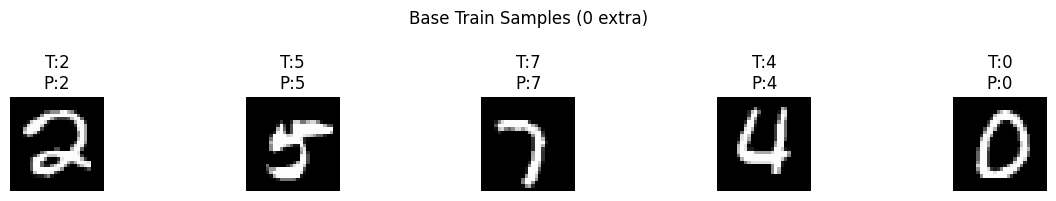

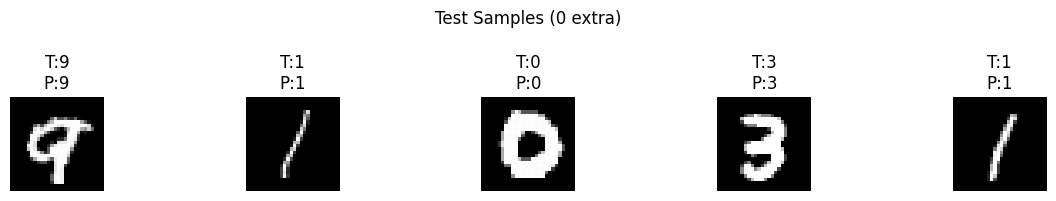

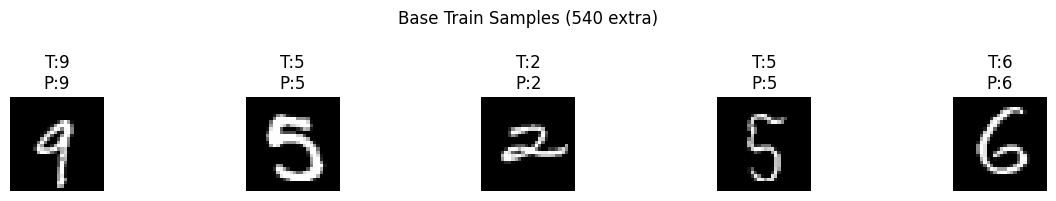

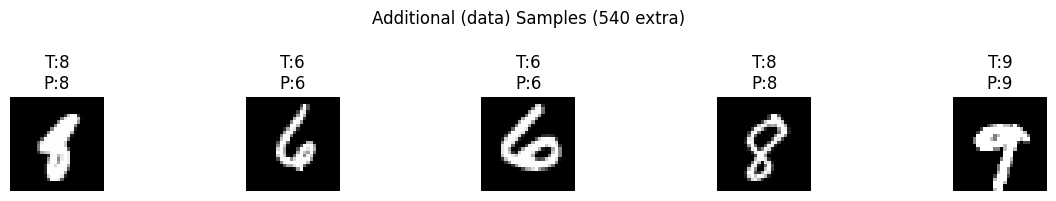

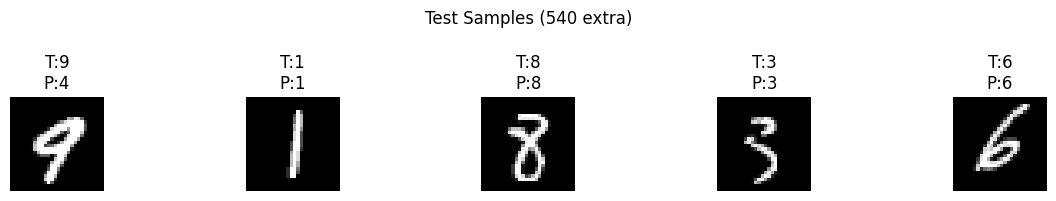

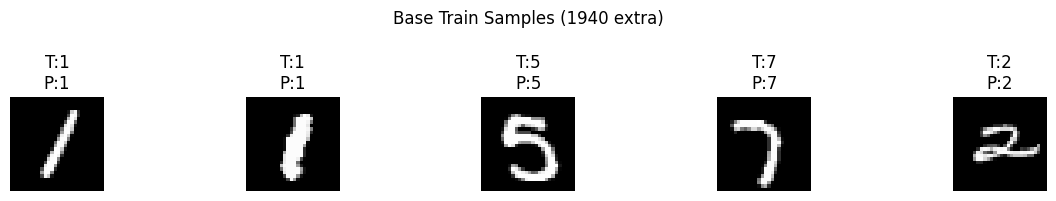

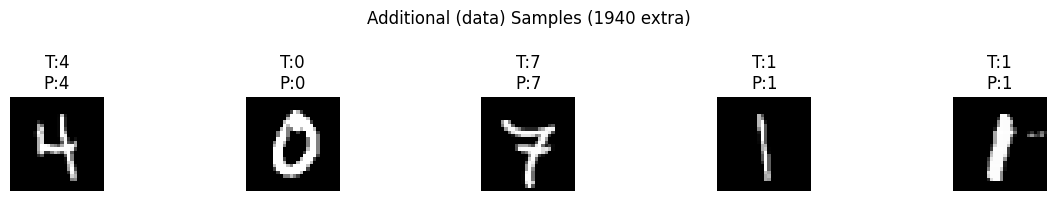

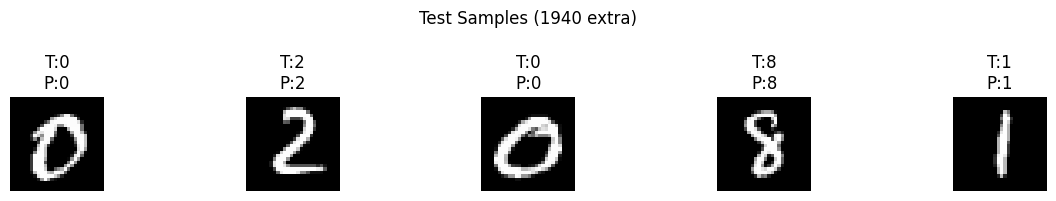

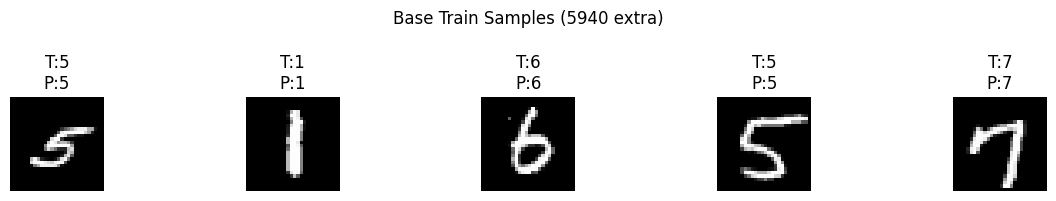

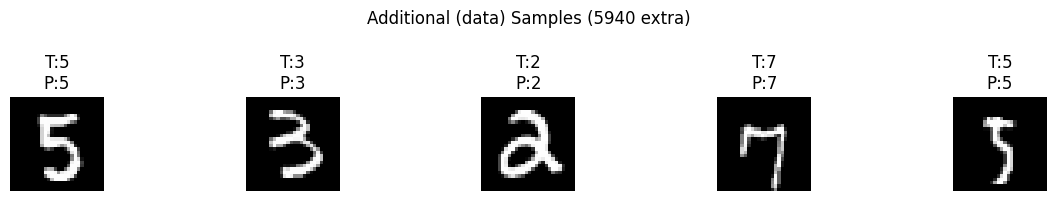

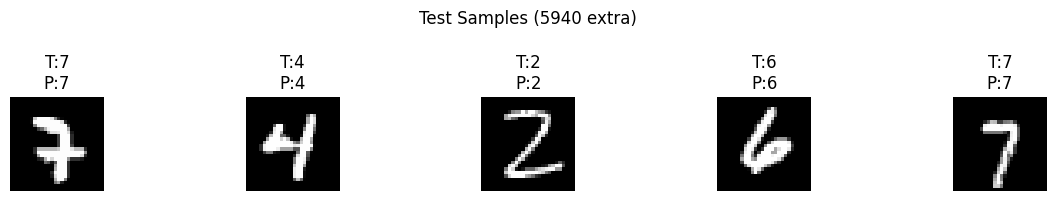

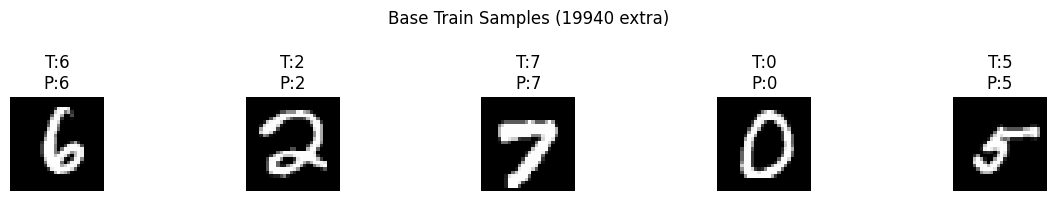

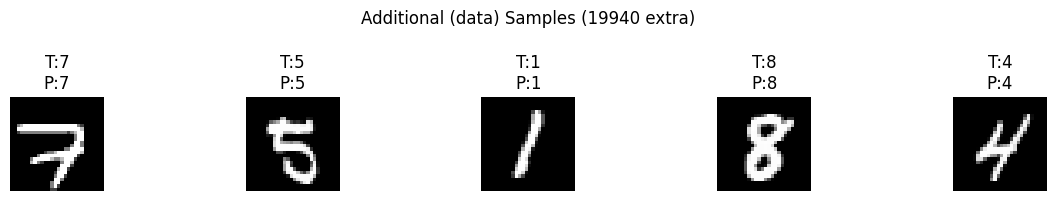

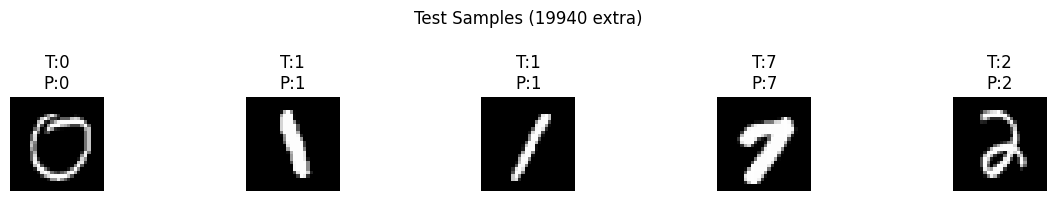

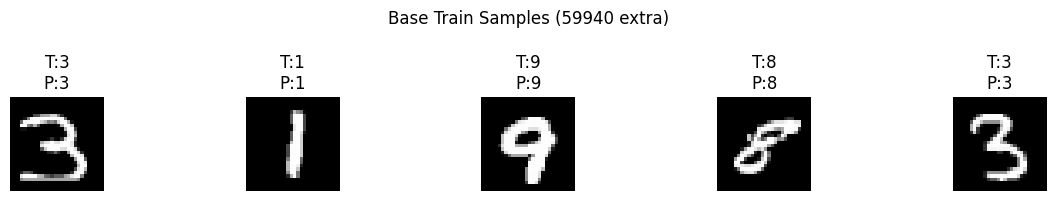

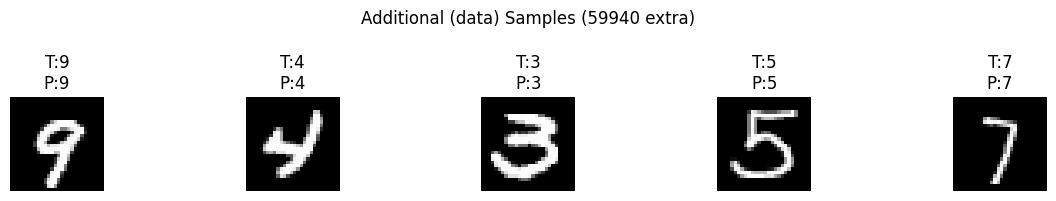

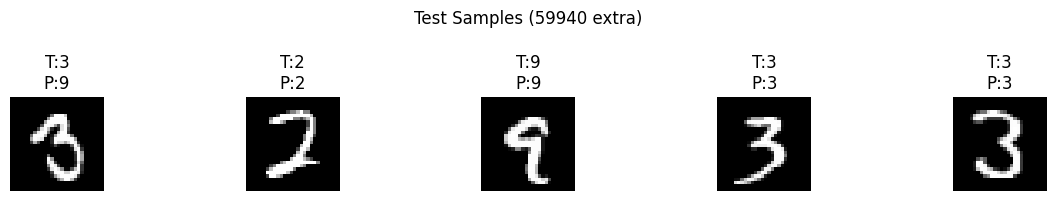

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
